# Assignment 3: Speech Emotion Recognition

## Downlaod the dataset and understand the format

For the SER, we will use the speech-emotion-recognition-en dataset from kaggle. This dataset consists of __four folders__ (Crema, Ravdess, Savee, Tess), we will only be working on the __Crema__ dataset.
The Crema dataset consistes of __7442 audio files__. Those audio files contain __different actors__ saying __different sentences__ with __different emotions__ and __different intensity__ (High, Low, Medium, xx)

In [1]:
import kagglehub
import os

crema_path = kagglehub.dataset_download("dmitrybabko/speech-emotion-recognition-en")
crema_path = os.path.join(crema_path, "Crema")

print("Path to dataset files:", crema_path)

Path to dataset files: /kaggle/input/speech-emotion-recognition-en/Crema


In [2]:
from collections import Counter

print(f'Number of audio files: {len(os.listdir(crema_path))}')

def extract_dataset_info(dataset_path):
    actor_ids = set()
    sentences = set()
    emotions = set()

    for file in os.listdir(dataset_path):
        if file.endswith('.wav'):
            parts = file.split('_')
            if len(parts) >= 4:
                actor_id = parts[0]
                sentence_id = parts[1]
                emotion_code = parts[2]

                actor_ids.add(actor_id)
                sentences.add(sentence_id)
                emotions.add(emotion_code)

    print(f"Number of unique actors: {len(actor_ids)}")
    print(f"Number of unique sentences: {len(sentences)}")
    print(f"    Sentences: {sorted(sentences)}")
    print(f"Number of unique emotions: {len(emotions)}")
    print(f"    Emotions: {sorted(emotions)}")

extract_dataset_info(crema_path)

Number of audio files: 7442
Number of unique actors: 91
Number of unique sentences: 12
    Sentences: ['DFA', 'IEO', 'IOM', 'ITH', 'ITS', 'IWL', 'IWW', 'MTI', 'TAI', 'TIE', 'TSI', 'WSI']
Number of unique emotions: 6
    Emotions: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']


In [3]:
# pip install librosa
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Function to load and play the audio file
def play_audio(file_path):
    # Load the audio file as a floating point time series
    audio, sr = librosa.load(file_path, sr = None)       # sr -> sampling rate; None -> uses the original sr of the file

    # Play the audio file
    display(Audio(data=audio, rate=sr))

    return audio, sr

# Function to plot the waveform of the audio
def plot_waveform(audio, sr, emotion=None):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform for Emotion: {emotion}' if emotion else 'Audio Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()


=== Disgust (DIS) ===


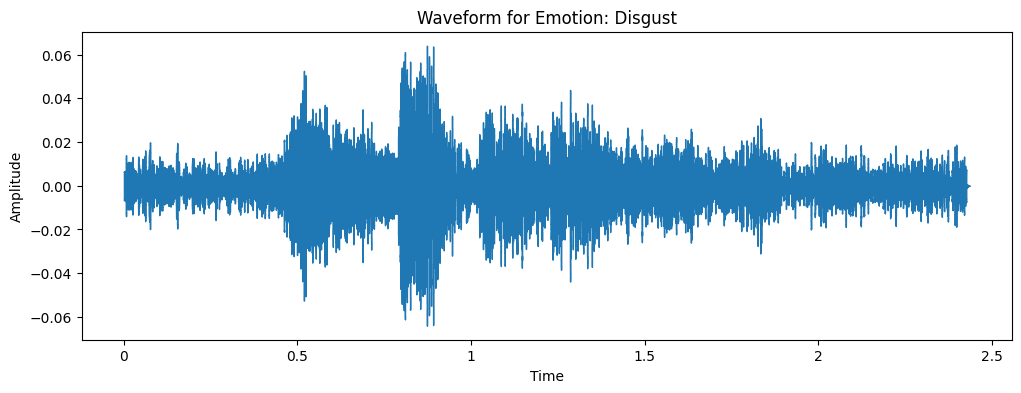


=== Happy (HAP) ===


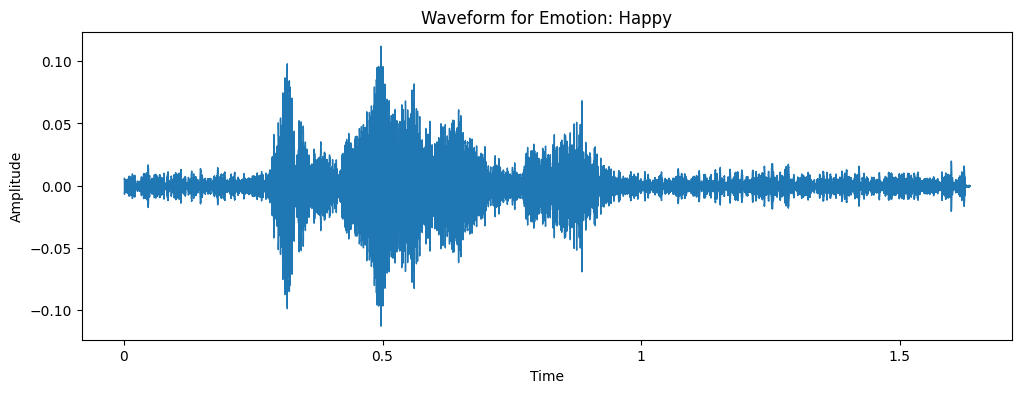


=== Sad (SAD) ===


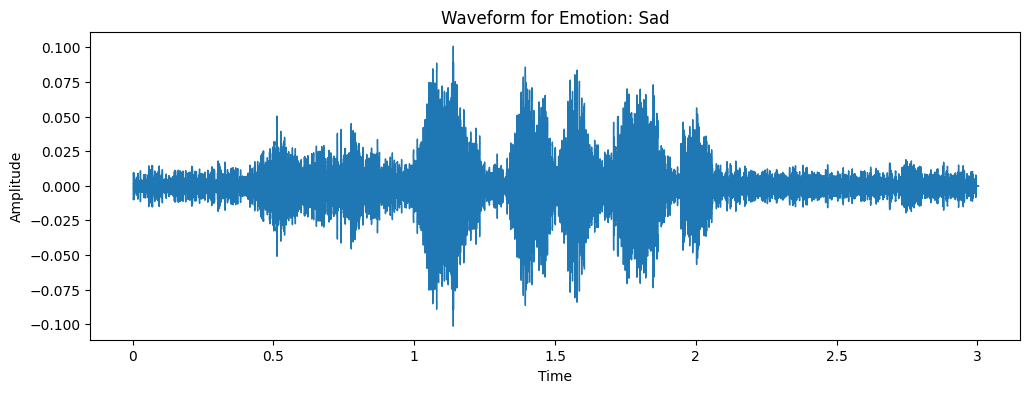


=== Neutral (NEU) ===


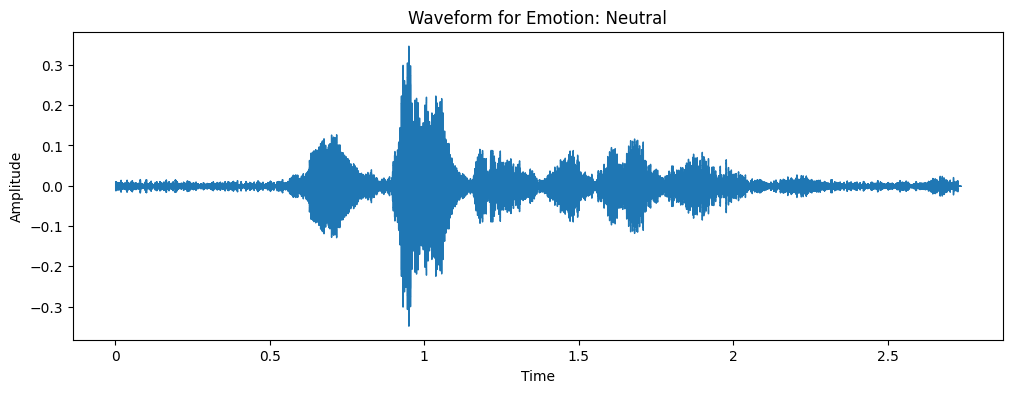


=== Fear (FEA) ===


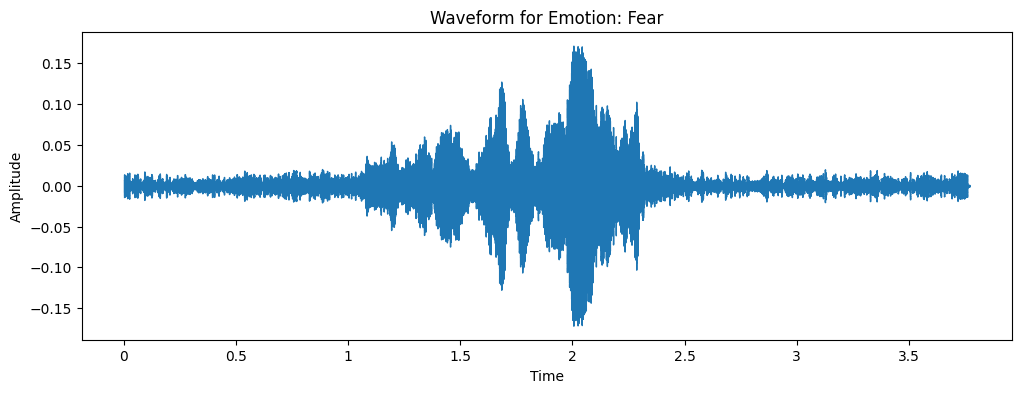


=== Anger (ANG) ===


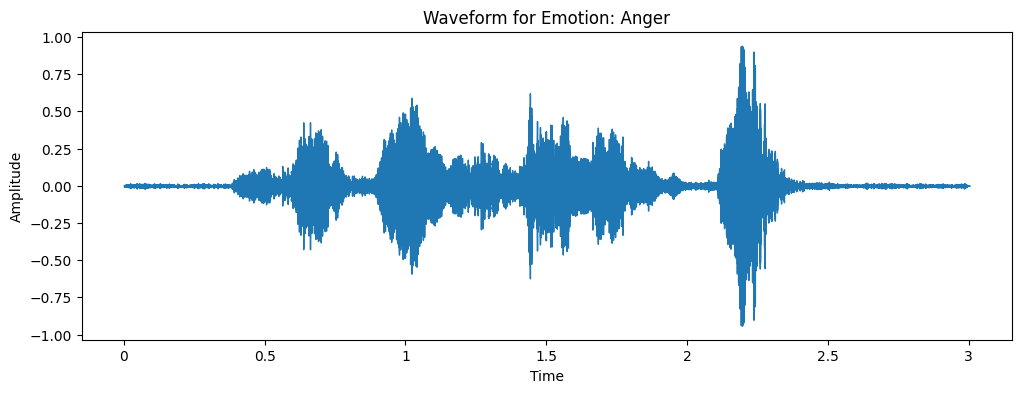

In [4]:
# Emotion mapping in CREMA
emotion_map = {
    'ANG': 'Anger',
    'DIS': 'Disgust',
    'FEA': 'Fear',
    'HAP': 'Happy',
    'NEU': 'Neutral',
    'SAD': 'Sad'
}

# Function that finds a sample for each emotion, loads it, plays it, and plot its wave form
def explore_emotion_classes(dataset_path, num_samples=1):
    # Get list of all audio files
    audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

    # Find a sample for each emotion
    samples = {}
    for file in audio_files:
        parts = file.split('_')
        info = {
            'actor': parts[0],                    # 1001, 1002, ...
            'sentence': parts[1],                 # DFA, IEO, IOM, ...
            'emotion': parts[2],                  # ANG, DIS, FEA, ...
            'intensity': parts[3].split('.')[0],  # HI, LO, MD, XX
            'filename': file
        }
        emotion = info['emotion']
        if emotion not in samples:     # Check if a sample exists for this emotion or not
            samples[emotion] = file
            if len(samples) == len(emotion_map):   # If found a sample for each emotion then break
                break

    # Process each sample
    for emotion_code, filename in samples.items():
        emotion_name = emotion_map.get(emotion_code, 'Unknown')
        print(f"\n=== {emotion_name} ({emotion_code}) ===")

        filepath = os.path.join(dataset_path, filename)
        audio, sr = play_audio(filepath)
        plot_waveform(audio, sr, emotion_name)

# Execute the exploration
explore_emotion_classes(crema_path)

## Data Augmentation

In [5]:
# data augmentation

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=4)


def stretch(data, rate=0.8):
  """Stretching data with some rate."""
  return librosa.effects.time_stretch(data, rate=rate)


## Create the Feature Space


### 1. Time Domain Features

#### (a) Zero Crossing Rate
Zero crossing rate is the rate of sign-changes of the signal during the duration of a particular frame.

In [6]:
def zero_crossing_rate(audio, frame_length=1048, hop_length=512):
  zcr = librosa.feature.zero_crossing_rate(audio, frame_length=frame_length, hop_length=hop_length)
  return np.squeeze(zcr)              # Returns 1d array having size equal the number of frames

#### (b) Energy
Energy is the sum of squares of the signal values, normalized by the respective frame length.

In [7]:
def rms(audio, frame_length=1048, hop_length=512):
  energy = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)
  return np.squeeze(energy)           # Returns 1d array having size equal the number of frames

In [8]:
def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)

In [9]:
def amplitude_envelope(audio, frame_size=1048, hop_length=512):
  amplitude_envelop = []
  # Calculate amplitude envelop for each frame:

  for i in range(0, len(audio), hop_length):
    amplitude_envelop_current_frame = max(audio[i:i+frame_size])
    amplitude_envelop.append( amplitude_envelop_current_frame)

  return np.array(amplitude_envelop)

In [10]:
import numpy as np

# Function to extract the time domain features from the audio
def extract_time_features(audio, sr):

    features = np.array([])
    features = np.hstack((features,
                        zero_crossing_rate(audio),
                        rms(audio),
                        # spc(audio, sr)
                        # amplitude_envelope(audio)
                        ))
    return features

In [11]:

import pandas as pd
def create_time_feature_dataframe(dataset_path):

    audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

    data = []
    labels = []
    for file in audio_files:
        filepath = os.path.join(dataset_path, file)

        # Get the emotion from filename
        emotion = file.split('_')[2]

        # Load audio file
        audio, sr = librosa.load(filepath, sr=None)

        # extract features and apply data augmentat
        time_features_1 = extract_time_features(audio, sr)
        data.append(time_features_1)
        labels.append(emotion)

        # stretched_audio = stretch(audio, rate=0.8)
        # time_features_2 = extract_time_features(stretched_audio, sr)
        # data.append(time_features_2)
        # labels.append(emotion)

        # pitched_audio = pitch(audio, sr, pitch_factor=0.7, random=False)
        # time_features_3 = extract_time_features(pitched_audio, sr)
        # data.append(time_features_3)
        # labels.append(emotion)


    df = pd.DataFrame(data)
    df['emotion'] = labels
    return df

time_df = create_time_feature_dataframe(crema_path)



In [12]:
time_df.head()

,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,emotion
0,0.013359,0.032443,0.031489,0.028626,0.031489,0.030534,0.035305,0.039122,0.047710,0.044847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
1,0.020038,0.034351,0.027672,0.045802,0.057252,0.053435,0.058206,0.051527,0.053435,0.065840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
2,0.022901,0.039122,0.042939,0.042939,0.041031,0.066794,0.109733,0.077290,0.030534,0.027672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
3,0.026718,0.046756,0.033397,0.035305,0.038168,0.047710,0.044847,0.038168,0.046756,0.042939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
4,0.017176,0.042939,0.048664,0.044847,0.036260,0.027672,0.026718,0.040076,0.041985,0.054389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS


In [13]:
time_df.fillna(0, inplace = True)
time_df.isna().sum().sum()

np.int64(0)

### 2. Frequency Domain Features
#### Mel Spectrogram

In [14]:
def extract_mel_spectrogram(audio, sr, n_mels=128, visualize=False):
    # Trim the silent parts
    audio, _ = librosa.effects.trim(audio, top_db=25)

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    if visualize:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.tight_layout()
        plt.show()

    return mel_spec_db      # Returns a 2d array of size n_mels * number of frames

In [15]:
# Function to extract all time and frequency domain features
def extract_freq_features(filepath):
    # Load audio file
    audio, sr = librosa.load(filepath, sr=None)

    # Frequency-domain features (Mel spectrogram)
    mel_spec = extract_mel_spectrogram(audio, sr)

    # Normalize the mel spectrogram
    epsilon = 1e-10
    mel_spec_mean = np.mean(mel_spec)
    mel_spec_std = np.std(mel_spec)

    # Handle case where std is zero
    if mel_spec_std < epsilon:
        mel_spec = mel_spec - mel_spec_mean
    else:
        mel_spec = (mel_spec - mel_spec_mean) / (mel_spec_std + epsilon)

    return {
        'filename': os.path.basename(filepath),
        'emotion': os.path.basename(filepath).split('_')[2],
        'mel_spectrogram': mel_spec
    }

In [16]:
import pandas as pd

# Function to create a feature dataframe of the audio dataset
def create_freq_feature_dataframe(dataset_path):

    audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

    data = []

    for file in audio_files:
        filepath = os.path.join(dataset_path, file)

        # Get the emotion from filename
        emotion = file.split('_')[2]

        # Extract features
        features = extract_freq_features(filepath)

        data.append(features)

    return pd.DataFrame(data)

feature_df = create_freq_feature_dataframe(crema_path)

In [17]:
feature_df.head()

,filename,emotion,mel_spectrogram
0,1028_TSI_DIS_XX.wav,DIS,"[[2.0600493, 2.1960082, 1.8995556, 1.7055526, ..."
1,1075_IEO_HAP_LO.wav,HAP,"[[1.0425919, 1.4528059, 1.8783413, 1.7705156, ..."
2,1084_ITS_HAP_XX.wav,HAP,"[[1.0071796, 0.69595855, 0.41182172, 0.3028291..."
3,1067_IWW_DIS_XX.wav,DIS,"[[0.52871746, 0.67717636, 0.63557607, 0.834233..."
4,1066_TIE_DIS_XX.wav,DIS,"[[1.3305007, 1.3701109, 1.5984623, 1.5330569, ..."


## Splitting the Dataset into Training, Validation, and Test Sets

#### Prepare data for 1D CNN





In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X_time = time_df.drop('emotion', axis=1)
# Encode labels
le = LabelEncoder()
y_time = le.fit_transform(time_df['emotion'])
y_time = to_categorical(y_time)


# Split into train+val (70%) and test (30%)
X_time_train_val, X_time_test, y_time_train_val, y_time_test = train_test_split(X_time, y_time, test_size=0.3, random_state=42, stratify=y_time)

# Split train+val into train (95%) and val (5%)
X_time_train, X_time_val, y_time_train, y_time_val = train_test_split(
    X_time_train_val, y_time_train_val, test_size=0.05, random_state=42, stratify=y_time_train_val)

# Standardization
scaler = StandardScaler()
X_time_train = scaler.fit_transform(X_time_train)
X_time_test = scaler.transform(X_time_test)
X_time_val = scaler.transform(X_time_val)

# Correct dims
X_time_train = np.expand_dims(X_time_train, axis=-1)
X_time_test = np.expand_dims(X_time_test, axis=-1)
X_time_val = np.expand_dims(X_time_val, axis=-1)

print(f"For Time Domain Features:\nTrain: {X_time_train.shape}, Val: {X_time_val.shape}, Test: {X_time_test.shape}")

For Time Domain Features:
Train: (4948, 314, 1), Val: (261, 314, 1), Test: (2233, 314, 1)


#### Prepare data for 2D CNN





In [19]:
# Prepare features
max_frames = max(mel.shape[1] for mel in feature_df['mel_spectrogram'])   # Find max frames in dataset
X_mel = np.array([np.pad(mel, ((0, 0), (0, max_frames - mel.shape[1])), mode='constant')[..., np.newaxis]
    for mel in feature_df['mel_spectrogram']])                            # Pad all to max length
# X_mel = np.array(feature_df['mel_spectrogram'].tolist())

# Encode labels
le = LabelEncoder()
y = le.fit_transform(feature_df['emotion'])
y = to_categorical(y)



In [20]:
# Split into train+val (70%) and test (30%)
X_mel_train_val, X_mel_test, y_train_val, y_test = train_test_split(X_mel, y, test_size=0.3, random_state=42, stratify=y)

# Split train+val into train (95%) and val (5%)
X_mel_train, X_mel_val, y_train, y_val = train_test_split(
    X_mel_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)

print(f"For Frequency Domain Features:\nTrain: {X_mel_train.shape}, Val: {X_mel_val.shape}, Test: {X_mel_test.shape}")

For Frequency Domain Features:
Train: (4948, 128, 157, 1), Val: (261, 128, 157, 1), Test: (2233, 128, 157, 1)


## Build CNN Model


### 1. 1D CNN for Time Domain Features

In [21]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)

In [22]:
def build_model(num_filters=16, kernerl_size=5, l2_val=0.001):
  model = Sequential()

  model.add(Conv1D(num_filters, kernel_size=5, strides=1, activation='relu', input_shape=(X_time_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=3, strides=2, padding="same"))

  model.add(Conv1D(2*num_filters, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(l2_val)))
  model.add(MaxPooling1D(pool_size=2, strides=2, padding="same"))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(4*num_filters, activation='relu', kernel_regularizer=l2(l2_val)))
  model.add(Dropout(0.5))

  # Output Layer
  model.add(Dense(6, activation="softmax"))
  return model

In [23]:
def train_model(model, X_time_train, y_train, epochs=30, batch_size=64, optimizer='adam'):
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(X_time_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_time_val, y_time_val))
  return history

In [24]:
def plot_history(history):
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  validation_acc = history.history['val_accuracy']
  validation_loss = history.history['val_loss']

  fig.set_size_inches(20,6)
  ax[0].plot(train_loss, label = 'Training Loss')
  ax[0].plot(validation_loss , label = 'validation Loss')
  ax[0].set_title('Training & validation Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(train_acc, label = 'Training Accuracy')
  ax[1].plot(validation_acc , label = 'validation Accuracy')
  ax[1].set_title('Training & validation Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()

In [25]:
def test_model(model, history, X_time_test, y_test):
  test_loss, test_acc = model.evaluate(X_time_test, y_test)

  y_pred = model.predict(X_time_test)
  y_pred = np.argmax(y_pred, axis=1)

  y_actual = np.argmax(y_test, axis=1)


  print(f"Accuracy = {test_acc}")
  print(f"F1-Score = {f1_score(y_actual, y_pred, average='weighted')}\n")
  return test_acc, y_actual, y_pred

def evaluate_model(history, y_actual, y_pred):
  # Plot history
  plot_history(history)

  # Confusion Matrix
  cm = confusion_matrix(y_actual, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
  disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
  plt.title("Confusion Matrix")
  plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.2934 - loss: 1.8927 - val_accuracy: 0.4061 - val_loss: 1.7055
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3730 - loss: 1.6590 - val_accuracy: 0.4253 - val_loss: 1.7435
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3959 - loss: 1.5853 - val_accuracy: 0.4176 - val_loss: 1.7587
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4148 - loss: 1.5466 - val_accuracy: 0.4598 - val_loss: 1.7511
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4182 - loss: 1.5307 - val_accuracy: 0.4444 - val_loss: 1.7456
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4432 - loss: 1.5023 - val_accuracy: 0.4368 - val_loss: 1.7956
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4496 - loss: 1.4918 - val_accuracy: 0.4444 - val_loss: 1.7637
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4534 - loss: 1.4819 - val_accuracy: 0.4559 - val_lo

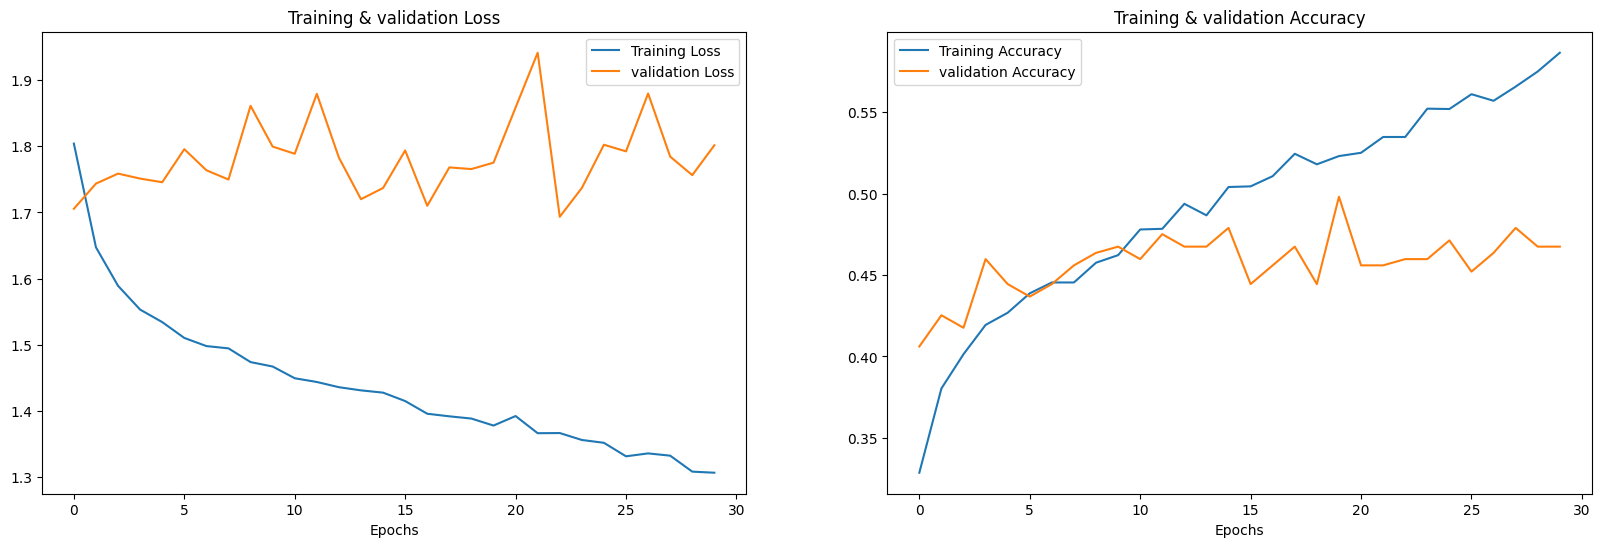

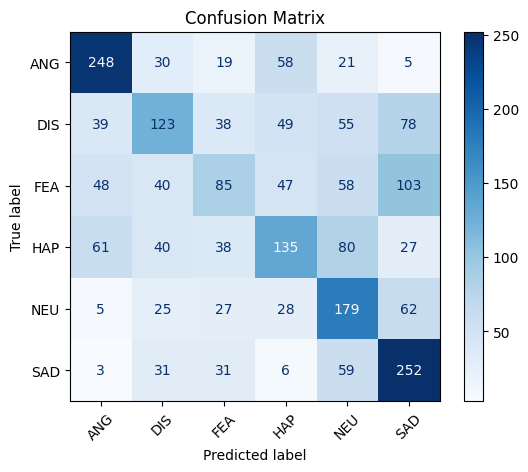

In [26]:
# try the model
cnn_1d = build_model(num_filters=32)
history = train_model(cnn_1d, X_time_train, y_time_train, epochs=30, batch_size=64, optimizer='adam')
_, y_actual, y_pred = test_model(cnn_1d, history, X_time_test, y_time_test)
evaluate_model(history, y_actual, y_pred)

#### Tuning the network to find the best model

Tune the batch size

In [61]:
batch_size = [16, 32, 64, 128, 256]
val_acc_tuning_batch_size = []
best_val_tuning_batch_size = 0
best_model_tuning_batch_size = None
best_history_batch = None
best_batch_size = 0

for size in batch_size:
  cnn_1d = build_model()
  history = train_model(cnn_1d, X_time_train, y_time_train, epochs=15, batch_size=size)
  val_acc, _, _ = test_model(cnn_1d, history, X_time_val, y_time_val)
  val_acc_tuning_batch_size.append(val_acc)

  if val_acc > best_val_tuning_batch_size:
    best_val_tuning_batch_size = val_acc
    best_model_tuning_batch_size = cnn_1d
    best_history_batch = history
    best_batch_size = size



Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2893 - loss: 1.7702 - val_accuracy: 0.3831 - val_loss: 1.5768
Epoch 2/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3561 - loss: 1.6112 - val_accuracy: 0.4215 - val_loss: 1.6549
Epoch 3/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3689 - loss: 1.5632 - val_accuracy: 0.4176 - val_loss: 1.5787
Epoch 4/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4047 - loss: 1.5358 - val_accuracy: 0.4100 - val_loss: 1.6245
Epoch 5/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4130 - loss: 1.5218 - val_accuracy: 0.4368 - val_loss: 1.6830
Epoch 6/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4089 - loss: 1.4961 - val_accuracy: 0.4483 - val_loss: 1.6094
Epoch 7/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4166 - loss: 1.4972 - val_accuracy: 0.4100 - val_loss: 1.6094
Epoch 8/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4258 - loss: 1.4987 - val_accuracy: 0.4330 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.2949 - loss: 1.8010 - val_accuracy: 0.4023 - val_loss: 1.6599
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3572 - loss: 1.6222 - val_accuracy: 0.4330 - val_loss: 1.6706
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3818 - loss: 1.5674 - val_accuracy: 0.4291 - val_loss: 1.6133
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3902 - loss: 1.5490 - val_accuracy: 0.4330 - val_loss: 1.5837
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4106 - loss: 1.5035 - val_accuracy: 0.4444 - val_loss: 1.6116
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4257 - loss: 1.4964 - val_accuracy: 0.4176 - val_loss: 1.5217
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4420 - loss: 1.4675 - val_accuracy: 0.4406 - val_loss: 1.5938
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4348 - loss: 1.4774 - val_accuracy: 0.4674 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.2419 - loss: 1.8476 - val_accuracy: 0.3831 - val_loss: 1.7241
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3481 - loss: 1.6503 - val_accuracy: 0.4215 - val_loss: 1.6046
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3805 - loss: 1.5856 - val_accuracy: 0.4138 - val_loss: 1.6070
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3873 - loss: 1.5609 - val_accuracy: 0.4330 - val_loss: 1.6036
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4002 - loss: 1.5241 - val_accuracy: 0.4406 - val_loss: 1.5970
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4136 - loss: 1.5016 - val_accuracy: 0.4368 - val_loss: 1.6305
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4297 - loss: 1.4939 - val_accuracy: 0.4598 - val_loss: 1.6278
Epoch 8/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4397 - loss: 1.4632 - val_accuracy: 0.4406 - val_loss: 1.6630
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2498 - loss: 1.8855 - val_accuracy: 0.3870 - val_loss: 1.7278
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3444 - loss: 1.6767 - val_accuracy: 0.4330 - val_loss: 1.6609
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3609 - loss: 1.6236 - val_accuracy: 0.4330 - val_loss: 1.6712
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3892 - loss: 1.5882 - val_accuracy: 0.4406 - val_loss: 1.7019
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3907 - loss: 1.5540 - val_accuracy: 0.4559 - val_loss: 1.6943
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4068 - loss: 1.5337 - val_accuracy: 0.4828 - val_loss: 1.6693
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4113 - loss: 1.5180 - val_accuracy: 0.4559 - val_loss: 1.7396
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4189 - loss: 1.5020 - val_accuracy: 0.4521 - val_loss: 1.7054
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.2338 - loss: 1.8767 - val_accuracy: 0.3678 - val_loss: 1.8504
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3162 - loss: 1.7375 - val_accuracy: 0.4215 - val_loss: 1.7733
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3450 - loss: 1.6549 - val_accuracy: 0.4483 - val_loss: 1.7288
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3581 - loss: 1.6166 - val_accuracy: 0.4559 - val_loss: 1.6875
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3661 - loss: 1.5975 - val_accuracy: 0.4521 - val_loss: 1.7035
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3918 - loss: 1.5631 - val_accuracy: 0.4598 - val_loss: 1.6989
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3957 - loss: 1.5518 - val_accuracy: 0.4521 - val_loss: 1.7011
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3998 - loss: 1.5290 - val_accuracy: 0.4444 - val_loss: 1

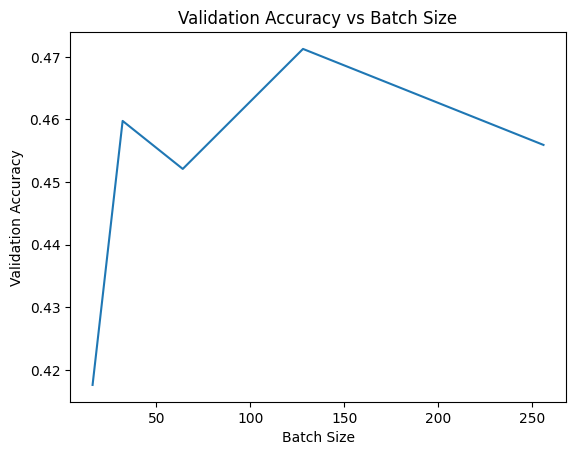

Best model has 128 batch size
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4311 - loss: 1.9071
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy = 0.4330497086048126
F1-Score = 0.4031622930134182



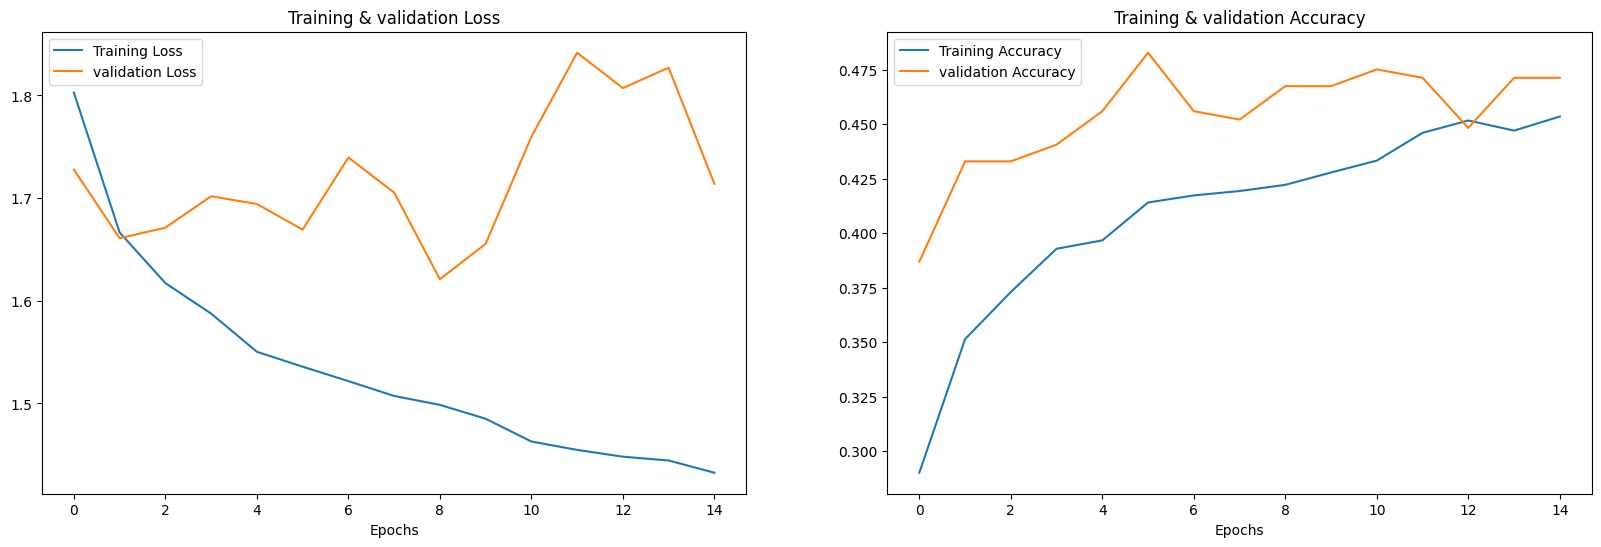

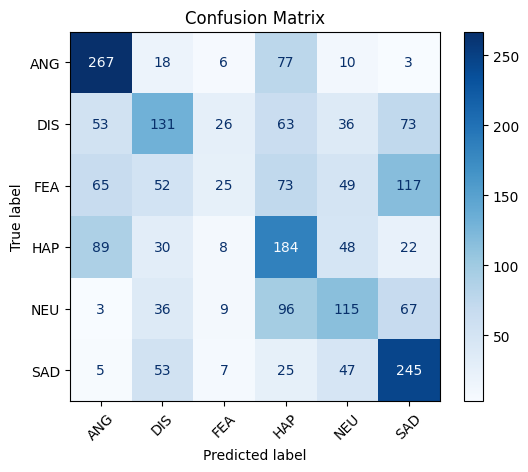

In [62]:
# plot the relation between batch size and val acc
plt.plot(batch_size, val_acc_tuning_batch_size)
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Batch Size')
plt.show()

print(f"Best model has {best_batch_size} batch size")
_, y_actual, y_pred = test_model(best_model_tuning_batch_size, best_history_batch, X_time_test, y_time_test)
evaluate_model(best_history_batch, y_actual, y_pred)

Tune the number of epochs and get the best model

In [63]:
epochs = [10, 20, 30, 40, 50, 60, 80, 100]
val_acc_tuning_epochs = []
best_val_tuning_epochs = 0
best_model_tuning_epochs = None
best_history_epoch = None
best_epoch = 0

for epoch in epochs:
  cnn_1d = build_model()
  history = train_model(cnn_1d, X_time_train, y_time_train, epochs=epoch, batch_size=best_batch_size)
  val_acc,_,_ = test_model(cnn_1d, history, X_time_val, y_time_val)
  val_acc_tuning_epochs.append(val_acc)
  if val_acc > best_val_tuning_epochs:
    best_val_tuning_epochs = val_acc
    best_model_tuning_epochs = cnn_1d
    best_history_epoch = history
    best_epoch = epoch


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.2725 - loss: 1.8446 - val_accuracy: 0.3908 - val_loss: 1.7308
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3522 - loss: 1.6648 - val_accuracy: 0.4061 - val_loss: 1.7107
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3765 - loss: 1.6046 - val_accuracy: 0.4291 - val_loss: 1.6488
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3837 - loss: 1.5641 - val_accuracy: 0.4444 - val_loss: 1.6597
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4005 - loss: 1.5444 - val_accuracy: 0.4406 - val_loss: 1.7095
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4063 - loss: 1.5274 - val_accuracy: 0.4253 - val_loss: 1.7042
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4136 - loss: 1.5003 - val_accuracy: 0.4521 - val_loss: 1.7331
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4252 - loss: 1.4868 - val_accuracy: 0.4598 - val_loss: 1.7699
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.2499 - loss: 1.8643 - val_accuracy: 0.3563 - val_loss: 1.7449
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3300 - loss: 1.6889 - val_accuracy: 0.3908 - val_loss: 1.6905
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3452 - loss: 1.6402 - val_accuracy: 0.4253 - val_loss: 1.6844
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3939 - loss: 1.5821 - val_accuracy: 0.4330 - val_loss: 1.7213
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3955 - loss: 1.5565 - val_accuracy: 0.4368 - val_loss: 1.6766
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4033 - loss: 1.5400 - val_accuracy: 0.4368 - val_loss: 1.6768
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4121 - loss: 1.5151 - val_accuracy: 0.4406 - val_loss: 1.6836
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4174 - loss: 1.4925 - val_accuracy: 0.4291 - val_loss: 1.7161
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2497 - loss: 1.8468 - val_accuracy: 0.3870 - val_loss: 1.7863
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3431 - loss: 1.6586 - val_accuracy: 0.4061 - val_loss: 1.7875
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3686 - loss: 1.6072 - val_accuracy: 0.4253 - val_loss: 1.6908
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3783 - loss: 1.5604 - val_accuracy: 0.4100 - val_loss: 1.7680
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3939 - loss: 1.5517 - val_accuracy: 0.4330 - val_loss: 1.7434
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3970 - loss: 1.5341 - val_accuracy: 0.4330 - val_loss: 1.7849
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4020 - loss: 1.5232 - val_accuracy: 0.4330 - val_loss: 1.7696
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4223 - loss: 1.4979 - val_accuracy: 0.4406 - val_loss: 1.8061
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.2592 - loss: 1.8637 - val_accuracy: 0.3831 - val_loss: 1.7713
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3451 - loss: 1.6722 - val_accuracy: 0.4023 - val_loss: 1.7230
Epoch 3/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3610 - loss: 1.6238 - val_accuracy: 0.4291 - val_loss: 1.6896
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3688 - loss: 1.5931 - val_accuracy: 0.4406 - val_loss: 1.7036
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3791 - loss: 1.5478 - val_accuracy: 0.4291 - val_loss: 1.7149
Epoch 6/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4089 - loss: 1.5276 - val_accuracy: 0.4483 - val_loss: 1.6954
Epoch 7/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4139 - loss: 1.5122 - val_accuracy: 0.4559 - val_loss: 1.6669
Epoch 8/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4090 - loss: 1.5026 - val_accuracy: 0.4368 - val_loss: 1.7476
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.2692 - loss: 1.8633 - val_accuracy: 0.3487 - val_loss: 1.9584
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3337 - loss: 1.6987 - val_accuracy: 0.3908 - val_loss: 1.9226
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3593 - loss: 1.6535 - val_accuracy: 0.4253 - val_loss: 1.8592
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3742 - loss: 1.5931 - val_accuracy: 0.4023 - val_loss: 1.8643
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4005 - loss: 1.5577 - val_accuracy: 0.4215 - val_loss: 1.7573
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3921 - loss: 1.5508 - val_accuracy: 0.4330 - val_loss: 1.8186
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4082 - loss: 1.5252 - val_accuracy: 0.4406 - val_loss: 1.8421
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4274 - loss: 1.4937 - val_accuracy: 0.4330 - val_loss: 1.8214
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.2407 - loss: 1.8693 - val_accuracy: 0.3870 - val_loss: 1.7199
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3382 - loss: 1.6724 - val_accuracy: 0.3946 - val_loss: 1.7361
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3743 - loss: 1.6052 - val_accuracy: 0.3716 - val_loss: 1.7422
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3841 - loss: 1.5748 - val_accuracy: 0.4100 - val_loss: 1.7212
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3990 - loss: 1.5496 - val_accuracy: 0.4215 - val_loss: 1.7196
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4116 - loss: 1.5198 - val_accuracy: 0.4100 - val_loss: 1.7031
Epoch 7/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4086 - loss: 1.4998 - val_accuracy: 0.3985 - val_loss: 1.7817
Epoch 8/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4332 - loss: 1.4852 - val_accuracy: 0.4368 - val_loss: 1.7624
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.2498 - loss: 1.8595 - val_accuracy: 0.4061 - val_loss: 1.7774
Epoch 2/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3388 - loss: 1.6699 - val_accuracy: 0.4100 - val_loss: 1.6553
Epoch 3/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3583 - loss: 1.6226 - val_accuracy: 0.4521 - val_loss: 1.6192
Epoch 4/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3846 - loss: 1.5771 - val_accuracy: 0.4598 - val_loss: 1.5883
Epoch 5/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3920 - loss: 1.5510 - val_accuracy: 0.4444 - val_loss: 1.5917
Epoch 6/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4089 - loss: 1.5235 - val_accuracy: 0.4559 - val_loss: 1.6192
Epoch 7/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4181 - loss: 1.5068 - val_accuracy: 0.4636 - val_loss: 1.6281
Epoch 8/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4234 - loss: 1.4984 - val_accuracy: 0.4521 - val_loss: 1.6467
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2707 - loss: 1.8311 - val_accuracy: 0.3640 - val_loss: 1.8012
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3363 - loss: 1.6804 - val_accuracy: 0.4176 - val_loss: 1.7035
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3664 - loss: 1.6195 - val_accuracy: 0.4100 - val_loss: 1.7388
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3696 - loss: 1.6097 - val_accuracy: 0.4406 - val_loss: 1.6804
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3928 - loss: 1.5525 - val_accuracy: 0.4521 - val_loss: 1.7100
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4068 - loss: 1.5327 - val_accuracy: 0.4368 - val_loss: 1.7369
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4036 - loss: 1.5214 - val_accuracy: 0.4444 - val_loss: 1.7145
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4152 - loss: 1.4962 - val_accuracy: 0.4521 - val_loss: 1

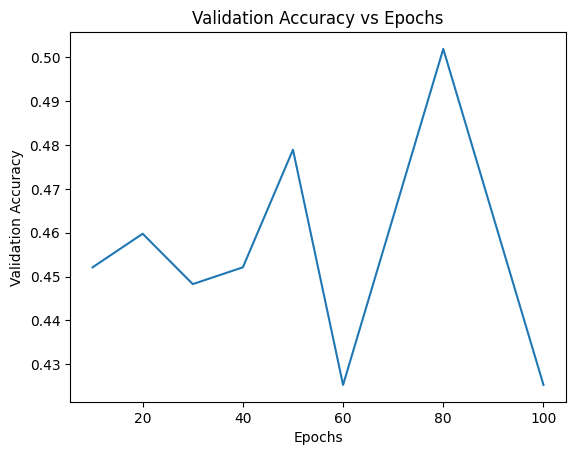

Best model has 80 epochs
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4486 - loss: 2.5312
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy = 0.445141077041626
F1-Score = 0.43660334010201735



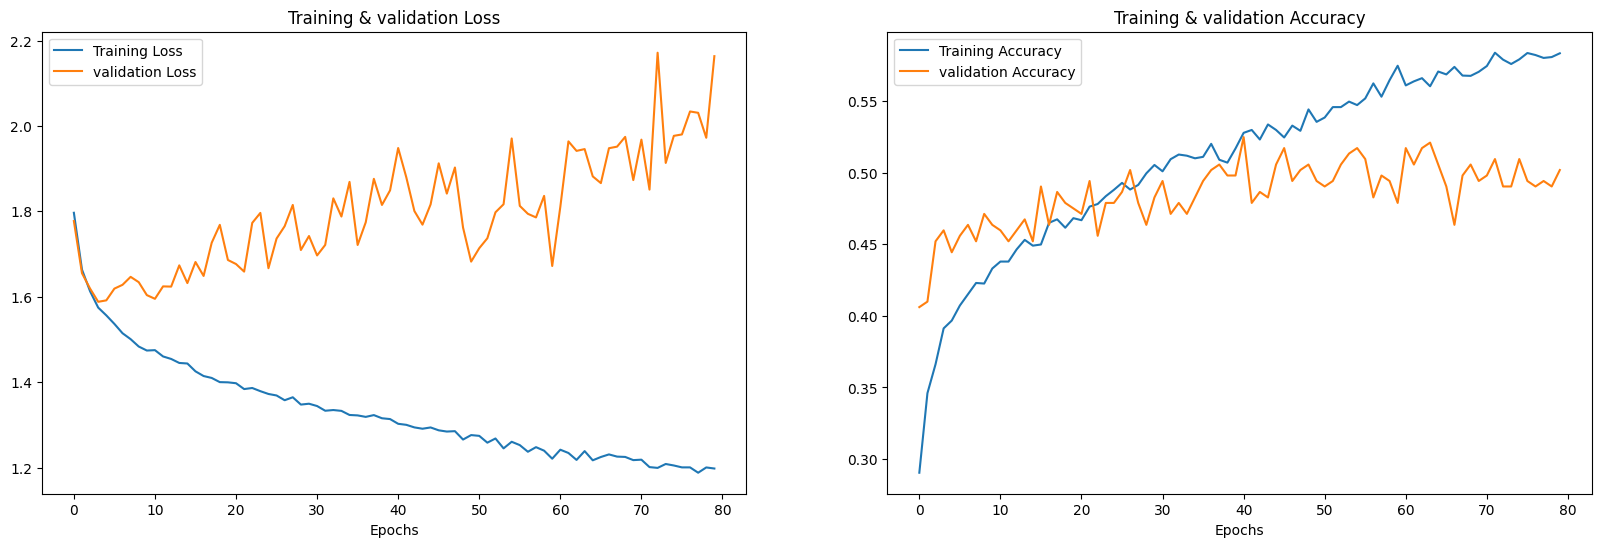

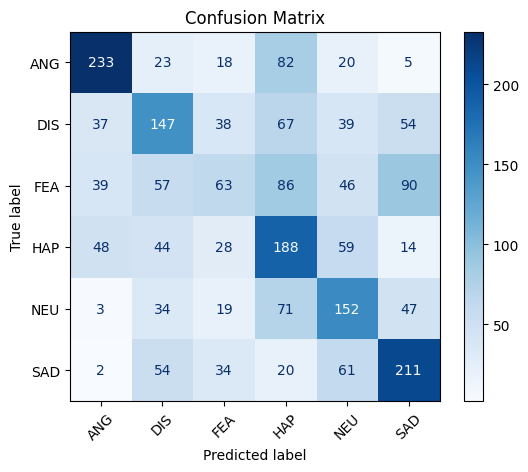

In [64]:
# plot the relation between epcohs and val acc
plt.plot(epochs, val_acc_tuning_epochs)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.show()

print(f"Best model has {best_epoch} epochs")
_, y_actual, y_pred = test_model(best_model_tuning_epochs, best_history_epoch, X_time_test, y_time_test)
evaluate_model(best_history_epoch, y_actual, y_pred)

Tune number of filters

In [65]:
num_filters = [8, 16, 32, 64]
val_acc_tuning_num_filters = []
best_val_tuning_num_filters = 0
best_model_tuning_num_filters = None
best_history_filters = None
best_num_filters = 0

for filter in num_filters:
  cnn_1d = build_model(num_filters=filter)
  history = train_model(cnn_1d, X_time_train, y_time_train, epochs=best_epoch, batch_size=best_batch_size)
  val_acc, _, _ = test_model(cnn_1d, history, X_time_val, y_time_val)
  val_acc_tuning_num_filters.append(val_acc)

  if val_acc > best_val_tuning_num_filters:
    best_val_tuning_num_filters = val_acc
    best_model_tuning_num_filters = cnn_1d
    best_history_filters = history
    best_num_filters = filter



Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.2534 - loss: 1.8035 - val_accuracy: 0.3793 - val_loss: 1.7171
Epoch 2/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3244 - loss: 1.6719 - val_accuracy: 0.3908 - val_loss: 1.7048
Epoch 3/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3465 - loss: 1.6181 - val_accuracy: 0.3946 - val_loss: 1.6456
Epoch 4/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3593 - loss: 1.5807 - val_accuracy: 0.3946 - val_loss: 1.6621
Epoch 5/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3608 - loss: 1.5777 - val_accuracy: 0.4100 - val_loss: 1.6613
Epoch 6/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3742 - loss: 1.5522 - val_accuracy: 0.4176 - val_loss: 1.6533
Epoch 7/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3782 - loss: 1.5396 - val_accuracy: 0.4483 - val_loss: 1.6591
Epoch 8/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4026 - loss: 1.5158 - val_accuracy: 0.4483 - val_loss: 1.6487


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2481 - loss: 1.8556 - val_accuracy: 0.3831 - val_loss: 1.8020
Epoch 2/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3324 - loss: 1.6829 - val_accuracy: 0.4023 - val_loss: 1.7333
Epoch 3/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3548 - loss: 1.6277 - val_accuracy: 0.4023 - val_loss: 1.6437
Epoch 4/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3773 - loss: 1.5861 - val_accuracy: 0.4253 - val_loss: 1.7082
Epoch 5/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3777 - loss: 1.5672 - val_accuracy: 0.4368 - val_loss: 1.6302
Epoch 6/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3939 - loss: 1.5412 - val_accuracy: 0.4368 - val_loss: 1.6686
Epoch 7/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3952 - loss: 1.5256 - val_accuracy: 0.4406 - val_loss: 1.6491
Epoch 8/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4108 - loss: 1.5095 - val_accuracy: 0.4291 - val_loss: 1.7075
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.2854 - loss: 1.9282 - val_accuracy: 0.4138 - val_loss: 1.6985
Epoch 2/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3725 - loss: 1.6945 - val_accuracy: 0.4176 - val_loss: 1.7021
Epoch 3/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3971 - loss: 1.6153 - val_accuracy: 0.4291 - val_loss: 1.7398
Epoch 4/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4138 - loss: 1.5810 - val_accuracy: 0.4444 - val_loss: 1.7470
Epoch 5/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4101 - loss: 1.5449 - val_accuracy: 0.4674 - val_loss: 1.7541
Epoch 6/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4390 - loss: 1.5148 - val_accuracy: 0.4330 - val_loss: 1.7641
Epoch 7/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4469 - loss: 1.4949 - val_accuracy: 0.4368 - val_loss: 1.7864
Epoch 8/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4564 - loss: 1.4793 - val_accuracy: 0.4521 - val_loss: 1.7614


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.3012 - loss: 2.1027 - val_accuracy: 0.3908 - val_loss: 1.8029
Epoch 2/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3784 - loss: 1.7277 - val_accuracy: 0.4291 - val_loss: 1.7103
Epoch 3/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4140 - loss: 1.6267 - val_accuracy: 0.4138 - val_loss: 1.7366
Epoch 4/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4248 - loss: 1.5803 - val_accuracy: 0.4253 - val_loss: 1.7374
Epoch 5/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4356 - loss: 1.5426 - val_accuracy: 0.4444 - val_loss: 1.7864
Epoch 6/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4523 - loss: 1.5217 - val_accuracy: 0.4406 - val_loss: 1.7258
Epoch 7/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4510 - loss: 1.5028 - val_accuracy: 0.4674 - val_loss: 1.7249
Epoch 8/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4613 - loss: 1.4925 - val_accuracy: 0.4444 - val_loss: 1.7

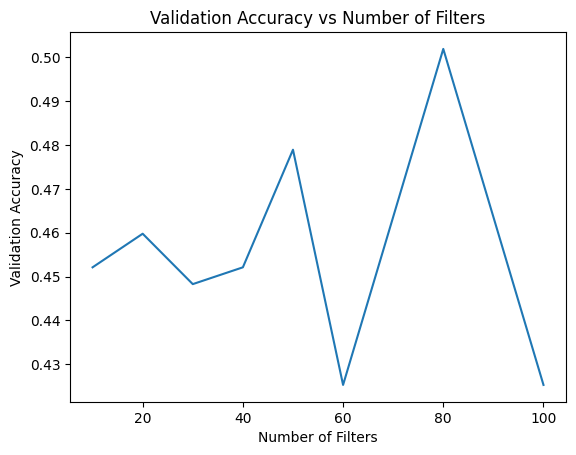

Best model has 8 number of filters
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4558 - loss: 2.1468
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy = 0.4527541399002075
F1-Score = 0.43536548067429487



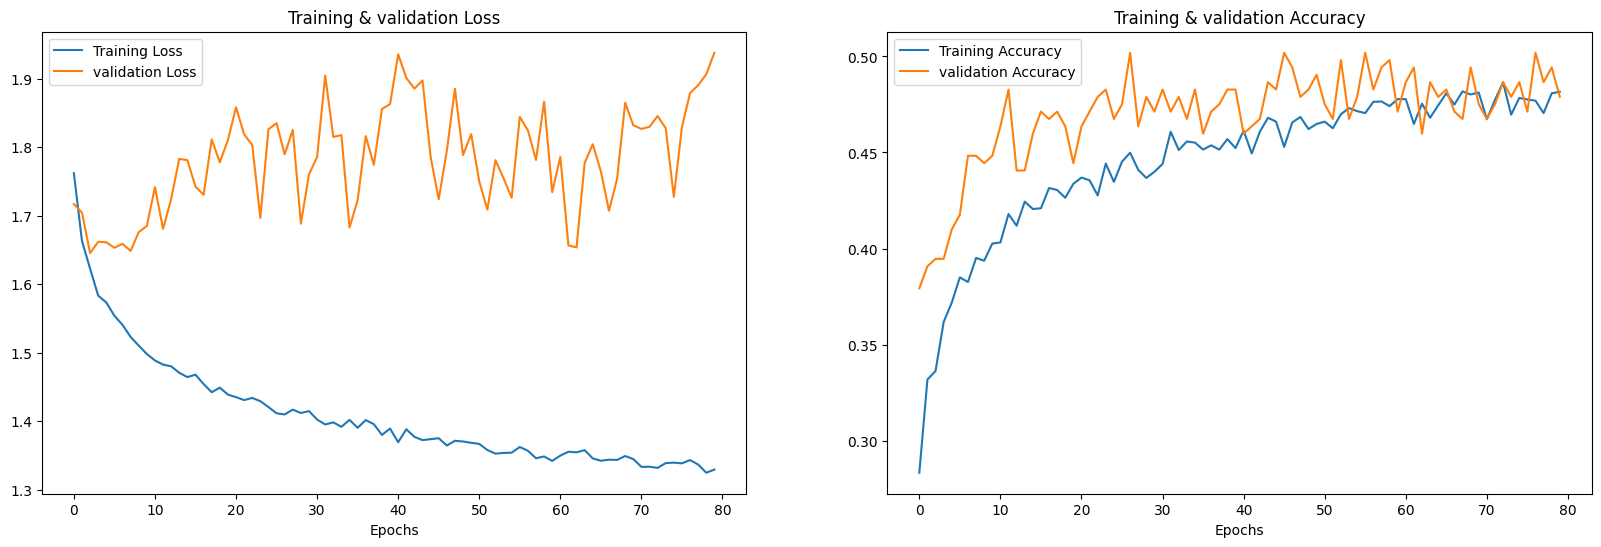

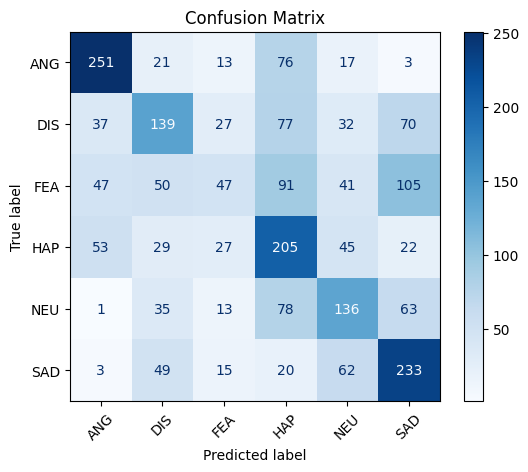

In [66]:
# plot the relation between number of filters and val acc
plt.plot(epochs, val_acc_tuning_epochs)
plt.xlabel('Number of Filters')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Number of Filters')
plt.show()

print(f"Best model has {best_num_filters} number of filters")
_, y_actual, y_pred = test_model(best_model_tuning_num_filters, best_history_filters, X_time_test, y_time_test)
evaluate_model(best_history_filters, y_actual, y_pred)

### 2. 2D CNN for Frequency Domain Features

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
import itertools

# Assumes X_mel_train, X_mel_val, X_mel_test, y_train, y_val, y_test, le are already defined

# Define a function to build, train, and evaluate the model
def build_and_train_model(filters1, filters2, dense_units, dropout_rate, batch_size, epochs, kernel_size):
    model = Sequential([
        InputLayer(input_shape=(128, X_mel_train.shape[2], 1)),

        Conv2D(filters1, kernel_size=kernel_size, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3)),

        Conv2D(filters2, kernel_size=kernel_size, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3)),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(le.classes_), activation='softmax')
    ])
    # default learning rate in adam is 0.001
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_mel_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_mel_val, y_val),
        verbose=0
    )

    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    loss, test_acc = model.evaluate(X_mel_test, y_test, verbose=0)

    return test_acc, train_acc, val_acc, model

# Define the new hyperparameter search space
filters1_list = [32]
filters2_list = [64]
dense_units_list = [128]
dropout_rates = [0.3, 0.36, 0.39, 0.42]
batch_sizes = [32]
kernel_sizes = [(3, 3), (5, 5)]
epochs_list = [10, 15, 20]

# Create all combinations of hyperparameters
combinations = list(itertools.product(filters1_list, filters2_list, dense_units_list,
                                      dropout_rates, batch_sizes, kernel_sizes, epochs_list))

results = []

# Run training and evaluation for each combination
for i, (f1, f2, dense, dr, bs, ks, ep) in enumerate(combinations):
    print(f"Config {i+1}/{len(combinations)}: Conv1={f1}, Conv2={f2}, Dense={dense}, Dropout={dr}, Batch={bs}, Kernel={ks}, Epochs={ep}")
    test_acc, train_acc, val_acc, _ = build_and_train_model(f1, f2, dense, dr, bs, ep, ks)
    print(f"Accuracies -> Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}% | Test: {test_acc*100:.2f}%\n")
    results.append(((f1, f2, dense, dr, bs, ks, ep), test_acc, train_acc, val_acc))

# Sort and print all results
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

Config 1/24: Conv1=32, Conv2=64, Dense=128, Dropout=0.3, Batch=32, Kernel=(3, 3), Epochs=10
Accuracies -> Train: 72.07% | Val: 57.47% | Test: 49.80%

Config 2/24: Conv1=32, Conv2=64, Dense=128, Dropout=0.3, Batch=32, Kernel=(3, 3), Epochs=15
Accuracies -> Train: 86.86% | Val: 53.26% | Test: 50.34%

Config 3/24: Conv1=32, Conv2=64, Dense=128, Dropout=0.3, Batch=32, Kernel=(3, 3), Epochs=20
Accuracies -> Train: 89.15% | Val: 54.41% | Test: 51.95%

Config 4/24: Conv1=32, Conv2=64, Dense=128, Dropout=0.3, Batch=32, Kernel=(5, 5), Epochs=10
Accuracies -> Train: 65.08% | Val: 54.41% | Test: 49.75%

Config 5/24: Conv1=32, Conv2=64, Dense=128, Dropout=0.3, Batch=32, Kernel=(5, 5), Epochs=15
Accuracies -> Train: 81.69% | Val: 53.26% | Test: 51.55%

Config 6/24: Conv1=32, Conv2=64, Dense=128, Dropout=0.3, Batch=32, Kernel=(5, 5), Epochs=20
Accuracies -> Train: 88.34% | Val: 52.87% | Test: 50.07%

Config 7/24: Conv1=32, Conv2=64, Dense=128, Dropout=0.36, Batch=32, Kernel=(3, 3), Epochs=10
Accurac

In [48]:
sorted_results[0]

((32, 64, 128, 0.3, 32, (3, 3), 20),
 0.5194805264472961,
 0.8914713263511658,
 0.5440613031387329)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy = 0.502910852432251
F1-Score = 0.48891260796229546



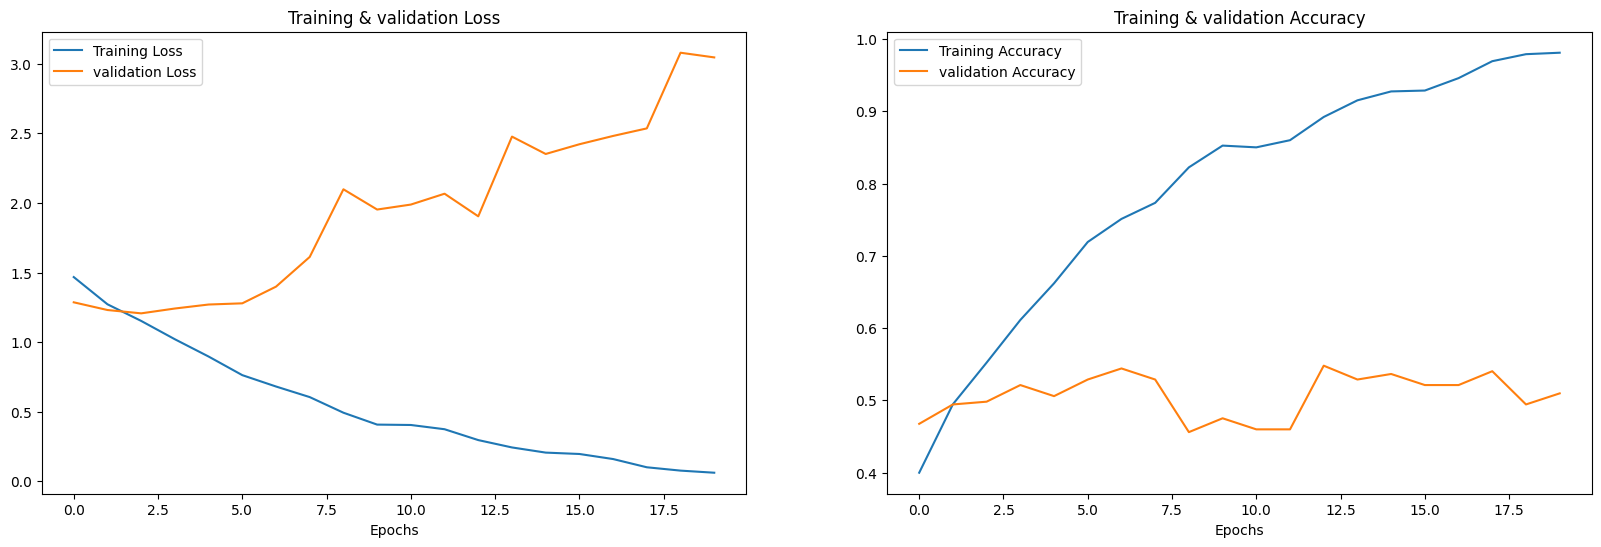

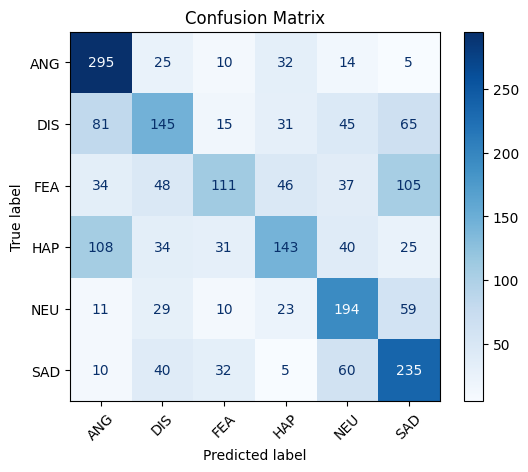

In [47]:
best_model_2d = sorted_results[0][0]
f1, f2, dense, dr, bs, ks, ep = best_model_2d
f1 = int(f1)
f2 = int(f2)
dense = int(dense)
dr = int(dr)
bs = int(bs)
ep = int(ep)

best_model_2d = Sequential([
    InputLayer(input_shape=(128, X_mel_train.shape[2], 1)),

    Conv2D(f1, kernel_size=ks, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(f2, kernel_size=ks, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3)),

    Flatten(),
    Dense(dense, activation='relu'),
    Dropout(dr),
    Dense(len(le.classes_), activation='softmax')
])
# default learning rate in adam is 0.001
best_model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

best_history = best_model_2d.fit(
    X_mel_train, y_train,
    epochs=ep,
    batch_size=bs,
    validation_data=(X_mel_val, y_val),
    verbose=0
)

best_train_acc_2d = history.history['accuracy'][-1]
best_val_acc_2d = history.history['val_accuracy'][-1]
best_test_loss_2d, best_test_acc_2d = best_model_2d.evaluate(X_mel_test, y_test, verbose=0)

y_pred_2d = best_model_2d.predict(X_mel_test)
y_pred_2d = np.argmax(y_pred_2d, axis=1)
y_actual_2d = np.argmax(y_test, axis=1)
print(f"Accuracy = {best_test_acc_2d}")
print(f"F1-Score = {f1_score(y_actual_2d, y_pred_2d, average='weighted')}\n")

train_acc = best_history.history['accuracy']
train_loss = best_history.history['loss']
validation_acc = best_history.history['val_accuracy']
validation_loss = best_history.history['val_loss']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(validation_loss , label = 'validation Loss')
ax[0].set_title('Training & validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(validation_acc , label = 'validation Accuracy')
ax[1].set_title('Training & validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_actual_2d, y_pred_2d)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()